## submit jobs to cluster

In [95]:
import os
from rosemary import jpt_in_notebook, jpt_setup; jpt_setup()
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm

first_N = None
embed_type = 'text_embedding'
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 1
test_run = bool(test_run)

####
md = 'mpnet'; model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'; normalize_embeddings = True

dataset = 'wizardlm'
## 
clustering_fn_list = []
# clustering_fn_list += [
#     f'cl=kmeans_nc={n_clusters}' for n_clusters in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# ]

clustering_fn_list = [
    f"cl=kmeans_md={md}_dist=cd_emb={'+'.join(embed_type.split('_'))}_nc={n_clusters}"
]

# first_N = 10_000
# clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}'
# clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}_bsz=256'


###

cmds = []
for clustering_fn in clustering_fn_list:
    save_dir = (f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/"
                f"clustering/{encode_fn_type+'/' if encode_fn_type!='sft' else ''}{model_name}/"
                f"{dataset+'(N='+str(first_N)+')' if first_N else dataset}/{clustering_fn}")

    cmd = f"""
    python note_pruning_clustering.py \
        --model_name {model_name} \
        --dataset {dataset} \
        --encode_fn_type {encode_fn_type} \
        --clustering_fn {clustering_fn} \
        --embed_type {embed_type} \
        {'--normalize_embeddings' if normalize_embeddings else ''} \
        {'--first_N '+str(first_N) if first_N else ''} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)

    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'cluster.{dataset}.{clustering_fn}', 
        nodes=1,
        num_cpus=64,
        cpu_mem=128,
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    print(cmd)
    cmds.append(cmd)
    
print(f'#cmds: {len(cmds)}')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Submiting job with:
{
    "job_name": "cluster.wizardlm.cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=[]",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 128,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": true,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning_clustering.py --model_name all-mpnet-base-v2 --dataset wizardlm --encode_fn_type input --clustering_fn cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=[] --embed_type text_embedding --normalize_embeddings --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/clustering/input/all-mpnet-base-v2/wizardlm/cl=kmeans_md=mpnet_dist=cd_emb=text+embedding_nc=[]
#cmds: 1


In [44]:

with open('note_pruning_cluster_test.sh', 'w') as f:
    f.write('\n'.join(['CUDA_VISIBLE_DEVICES=1 '+x for x in cmds]))
    
    

NameError: name 'cmds' is not defined

## analyze clustering results

In [11]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from note_pruning_clustering import get_clustering_info_df

dataset, model_name, n_clusters, clustering_fn = [], [], [], []

df = get_clustering_info_df()

dataset = ['wizardlm']; model_name = ['mpnet']; n_clusters = []; clustering_fn = ['cl=kmeans_']
dataset = ['wizardlm']; model_name = ['bge']; n_clusters = []; clustering_fn = ['faiss']
dataset = ['wizardlm']; model_name = ['llama']; n_clusters = []; clustering_fn = ['cd_emb=grad'] # 'cd_emb=text'
dataset = ['ultrachat15']; model_name = ['mpnet']; n_clusters = []; clustering_fn = []
dataset = ['ultrachat15']; model_name = ['mistral']; n_clusters = []; clustering_fn = ['cd_emb=text']

def filter_fn(row):
    b = True
    if dataset:
        b &= any(y in row['dataset'] for y in dataset)
    if model_name:
        b &= any(y in row['model_name'] for y in model_name)
    if n_clusters:
        b &= any(y in row['n_clusters'] for y in n_clusters)
    if clustering_fn:
        b &= any(y in row['clustering_fn'] for y in clustering_fn)
    return b

df = df[df.apply(filter_fn, 1)]
df = df.sort_values(['n_clusters'])
df


,n_clusters,N,dataset,model_name,encode_fn_type,clustering_fn,time_elapsed,cent_dist_l2_vs_cd_spearmanr,$\text{inertia}\downarrow$,$\text{silhouette_score_cd}\uparrow$,$\text{silhouette_score_l2}\uparrow$,$\text{variance_ratio}\uparrow$,$\text{davies_bouldin_index}\downarrow$,cluster_sizes_min,cluster_sizes_mean,cluster_sizes_max
12,100,1461456,ultrachat15,mistral-7b+lora:r=256:a=256,sft,cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text...,49.711,1.0,485907.312,0.101,0.056,12885.864,2.982,5394,14614,33073
13,200,1461456,ultrachat15,mistral-7b+lora:r=256:a=256,sft,cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text...,71.390,1.0,441442.531,0.090,0.050,7669.094,2.972,1339,7307,17643
14,300,1461456,ultrachat15,mistral-7b+lora:r=256:a=256,sft,cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text...,88.952,1.0,419238.469,0.086,0.047,5591.206,2.982,1168,4871,22380
15,400,1461456,ultrachat15,mistral-7b+lora:r=256:a=256,sft,cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text...,115.099,1.0,403325.531,0.078,0.044,4477.838,2.963,91,3653,7936
16,500,1461456,ultrachat15,mistral-7b+lora:r=256:a=256,sft,cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text...,145.107,1.0,391288.125,0.074,0.041,3765.166,2.973,385,2922,6845
17,600,1461456,ultrachat15,mistral-7b+lora:r=256:a=256,sft,cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=text...,174.779,1.0,382027.375,0.073,0.041,3262.813,2.939,385,2435,6282


In [45]:
xs = df['n_clusters'].tolist()

fig, axs = plt.subplots(1,2,figsize=(10,5))
for i, k in enumerate([f'$\\text{{inertia}}\\downarrow$',
                       f'$\\text{{silhouette_score_cd}}\\uparrow$']):
    ax = axs[i]
    ys = [df[df['n_clusters']==x].iloc[0][k] for x in xs]
    ax.plot(xs, ys)
    ax.set_title(k.replace('\\', ' '))

NameError: name 'df' is not defined

## clustering code base


In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    print(os.environ['CUDA_VISIBLE_DEVICES'].split(','))
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[0] 
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
# !nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


['4', '5']
4


In [2]:
import re
import argparse
import json
import pickle
import string
import time
import matplotlib.pyplot as plt

import numpy as np
import scipy
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sklearn.cluster import KMeans, AgglomerativeClustering
import torch
from tqdm import tqdm
import pandas as pd

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

import time
from note_pruning_analysis import (
    get_lm_output,
    get_dataset,
)
from note_pruning_clustering import (
    pairwise_cosine_distance,
    clustering_sort_by_cluster_size,
    clustering_algorithm_scores,
    clustering_dist_to_centroids,
    clustering_knn_withincluster,
    clustering_run,
    clustering_compute_and_save_results,
    sklearn_compute_inertia_dense,
)

from llm.submit import get_host_info
if get_host_info()['arch'] == 'x86_64': import faiss

In [12]:
md = 'mpnet'; model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'; normalize_embeddings = True
# md = 'bge'; model_name = 'bge-large-en-v1.5'; encode_fn_type = 'input'; normalize_embeddings = True
# md = 'llama7b'; model_name = 'llama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; normalize_embeddings = True

dataset = 'wizardlm'

first_N = 10_000
# first_N = None

# clustering_fn = f'cl=kmeans_nc={n_clusters}'
# clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}_bsz=4096'
# clustering_fn = f'cl=kmeansfaissl2_nc={n_clusters}'
# clustering_fn = f'cl=kmeansfaisscd_nc={n_clusters}'

n_clusters = 200

embed_type = 'text_embedding'
# embed_type = 'grad_rp_loraB'
# clustering_fn = f"cl=kmeansfaisscd_md={md}_dist=cd_emb={'+'.join(embed_type.split('_'))}_nc={n_clusters}"
# clustering_fn = f"cl=kmeansfaissl2_md={md}_dist=l2_emb={'+'.join(embed_type.split('_'))}_nc={n_clusters}"

clustering_fn = f"cl=hdbscancd_md={md}_dist=cd_emb={'+'.join(embed_type.split('_'))}_ms=3"


print(md, dataset, clustering_fn)

mpnet wizardlm cl=hdbscancd_md=mpnet_dist=cd_emb=text+embedding_ms=3


In [5]:
save_dir = os.path.join('clustering', encode_fn_type, model_name, dataset, clustering_fn+'_test')
os.makedirs(save_dir, exist_ok=True)
save_dir

'clustering/input/all-mpnet-base-v2/wizardlm/cl=hdbscancd_md=mpnet_dist=cd_emb=text+embedding_nc=200_test'

In [6]:

ds = get_dataset(dataset, processed=True)
if encode_fn_type == 'input':
    def get_user_prompt_fn(example):
        example['text'] = example['messages'][0]['content']
        return example
    ds = ds.map(get_user_prompt_fn, num_proc=16)
elif encode_fn_type == 'sft':
    def combine_first_turn_conv_fn(example):
        example['text'] = "[USER]"+" "*20+example['messages'][0]['content']+" "*20+\
                          "[ASSISTANT]"+" "*20+example['messages'][1]['content']
        return example
    ds = ds.map(combine_first_turn_conv_fn, num_proc=16)

ds

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Loading cached processed dataset at /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/wizardlm/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-b089bdb80a735e3f_*_of_00016.arrow


Dataset({
    features: ['dataset', 'id', 'messages', 'text'],
    num_rows: 143000
})

In [7]:
d = get_lm_output(dataset, 
                  model_name, 
                  encode_fn_type=encode_fn_type,
                  return_text_embedding=True,)

if embed_type not in ['text_embedding', 'grad_rp_loraB']:
    raise ValueError(f'embed_type={embed_type} not supported.')
X = d[embed_type]
if normalize_embeddings:
    X = X / np.maximum(np.linalg.norm(X, axis=-1, keepdims=True), 1e-8) # possibly divide by zero.
nan_rows = np.isnan(X).any(-1)
if nan_rows.any():
    print(f'Found {nan_rows.sum()} ({100*nan_rows.sum()/len(X)} pct) nan rows in embeddings. ')
    
if first_N:
    ds = ds.select(range(first_N))
    X = X[:first_N]

hdbscan.dist_metrics.ArccosDistance

In [27]:
run_name = clustering_fn

match = re.search(r'cl=([^_]+)', run_name)
clustering_algo = match.group(1)

print(run_name)

import hdbscan
assert(clustering_algo in ['hdbscanl2', 'hdbscancd'])
dist = clustering_algo.replace('hdbscan', '')
dist = 'l2'
match = re.search(r'ms=([^_]+)', run_name)
min_samples = int(match.group(1))
db = hdbscan.HDBSCAN(
    metric=(hdbscan.dist_metrics.METRIC_MAPPING['cosine'] if dist=='cd' else 'euclidean'),
    min_samples=min_samples,
    min_cluster_size=100,
)
db.fit(X)
Y = db.labels_
C = np.vstack([X[Y==i].mean(0) for i in np.unique(Y)])


labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print(f"Silhouette Coefficient: {sklearn.metrics.silhouette_score(X, labels):.3f}")



cl=hdbscancd_md=mpnet_dist=cd_emb=text+embedding_ms=3
Estimated number of clusters: 3
Estimated number of noise points: 24
Silhouette Coefficient: 0.605


In [22]:
import sklearn

sklearn.neighbors.BallTree.valid_metrics()

['euclidean',
 'l2',
 'minkowski',
 'p',
 'manhattan',
 'cityblock',
 'l1',
 'chebyshev',
 'infinity',
 'seuclidean',
 'mahalanobis',
 'hamming',
 'canberra',
 'braycurtis',
 'jaccard',
 'dice',
 'rogerstanimoto',
 'russellrao',
 'sokalmichener',
 'sokalsneath',
 'haversine',
 'pyfunc']

In [8]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)
X.shape

(750, 2)

In [2]:
import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}"
)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")


Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


In [46]:
db.labels_.shape

(750,)

In [42]:

import hdbscan


db = hdbscan.HDBSCAN(metric='euclidean', min_cluster_size=5, min_samples=5)
db.fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}"
)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")



Estimated number of clusters: 3
Estimated number of noise points: 29
Homogeneity: 0.931
Completeness: 0.838
V-measure: 0.882
Adjusted Rand Index: 0.925
Adjusted Mutual Information: 0.882
Silhouette Coefficient: 0.613


In [43]:
# hdbscan.dist_metrics.METRIC_MAPPING
# [db.probabilities_==0]

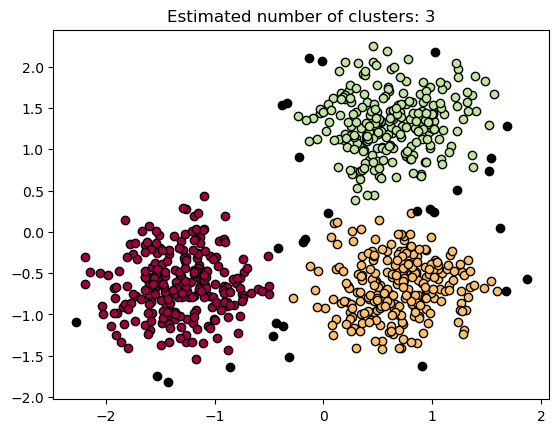

In [44]:
import matplotlib.pyplot as plt

unique_labels = set(labels)
# core_samples_mask = np.zeros_like(labels, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[np.where(db.labels_ != -1)]

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()


In [192]:


info = {}
info['N'] = len(X)
info['dataset'] = dataset
info['model_name'] = model_name
info['encode_fn_type'] = encode_fn_type
info['clustering_fn'] = clustering_fn

t0 = time.time()
Y, C = clustering_run(clustering_fn, X)
info['time_elapsed'] = time.time()-t0
info['scores'] = {}
info['scores'].update({'inertia': sklearn_compute_inertia_dense(X, Y, C)})
info['scores'].update(clustering_algorithm_scores(X, Y))

df = clustering_compute_and_save_results(X, Y, C, ds=ds, save_dir=save_dir)
info['cent_dist_l2_vs_cd_spearmanr'] = float(scipy.stats.spearmanr(
    df['cent_dist_l2'].to_numpy(), df['cent_dist_cd'].to_numpy()).statistic)
info['cluster_sizes'] = np.unique(Y, return_counts=True)[1].tolist()

with open(os.path.join(save_dir, 'info.json'), 'w') as f:
    json.dump(info, f, ensure_ascii=False, indent=4)


Sampling a subset of 51200 / 143000 for training
Clustering 51200 points in 1024D to 200 clusters, redo 1 times, 30 iterations
  Preprocessing in 0.23 s
  Iteration 29 (15.26 s, search 13.49 s): objective=21083.8 imbalance=1.102 nsplit=0       
